# Testing MSE in Consistency Denoising

/home/anton/source/torch-env/lib/python3.12/site-packages/diffusers/models/transformers/transformer_2d.py:34: FutureWarning: `Transformer2DModelOutput` is deprecated and will be removed in version 1.0.0. Importing `Transformer2DModelOutput` from `diffusers.models.transformer_2d` is deprecated and this will be removed in a future version. Please use `from diffusers.models.modeling_outputs import Transformer2DModelOutput`, instead.
  deprecate("Transformer2DModelOutput", "1.0.0", deprecation_message)


Loading pipeline components...:   0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

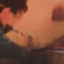

In [2]:
import torch
from diffusers import ConsistencyModelPipeline

device = "cuda"
model_id_or_path = "openai/diffusers-cd_imagenet64_l2"
pipe = ConsistencyModelPipeline.from_pretrained(model_id_or_path, torch_dtype=torch.float16)
pipe.to(device)

#pipe.unet = torch.compile(pipe.unet, mode="reduce-overhead", fullgraph=True)

# Multistep sampling
# Timesteps can be explicitly specified; the particular timesteps below are from the original GitHub repo:
# https://github.com/openai/consistency_models/blob/main/scripts/launch.sh#L83
image = pipe(num_inference_steps=20).images[0]
image

In [3]:
pipe.scheduler.sigmas

tensor([8.0000e+01, 6.0117e+01, 4.4630e+01, 3.2697e+01, 2.3610e+01, 1.6780e+01,
        1.1719e+01, 8.0265e+00, 5.3800e+00, 3.5197e+00, 2.2404e+00, 1.3824e+00,
        8.2294e-01, 4.6998e-01, 2.5563e-01, 1.3120e-01, 6.2762e-02, 2.7525e-02,
        1.0812e-02, 3.6766e-03, 2.0000e-03])

In [4]:
pipe.scheduler.sigmas

tensor([8.0000e+01, 6.0117e+01, 4.4630e+01, 3.2697e+01, 2.3610e+01, 1.6780e+01,
        1.1719e+01, 8.0265e+00, 5.3800e+00, 3.5197e+00, 2.2404e+00, 1.3824e+00,
        8.2294e-01, 4.6998e-01, 2.5563e-01, 1.3120e-01, 6.2762e-02, 2.7525e-02,
        1.0812e-02, 3.6766e-03, 2.0000e-03])

In [5]:
pipe.scheduler.timesteps

tensor([ 1095.5067,  1024.0748,   949.6027,   871.8200,   790.4186,   705.0453,
          615.2925,   520.6865,   420.6723,   314.5939,   201.6680,    80.9495,
          -48.7176,  -188.7668,  -341.0065,  -507.7631,  -692.0998,  -898.1648,
        -1131.7736, -1401.4425], dtype=torch.float64)

In [6]:
pipe.scheduler.sigma_to_t(2e-3)

-1553.652024605548

## Consistency Model Pipeline

In [7]:
generator = torch.Generator(device=device)

In [8]:
generator.device.type

'cuda'

tensor([ 1095.5067,  1060.1552,  1024.0748,   987.2349,   949.6027,   911.1435,
          871.8200,   831.5925,   790.4186,   748.2525,   705.0453,   660.7442,
          615.2925,   568.6287,   520.6865,   471.3938,   420.6723,   368.4367,
          314.5939,   259.0417,   201.6680,   142.3495,    80.9495,    17.3166,
          -48.7176,  -117.3416,  -188.7668,  -263.2317,  -341.0065,  -422.3993,
         -507.7631,  -597.5054,  -692.0998,  -792.1010,  -898.1648, -1011.0740,
        -1131.7736, -1261.4188, -1401.4425, -1553.6520], device='cuda:0',
       dtype=torch.float64)
tensor([8.0000e+01, 6.9451e+01, 6.0117e+01, 5.1880e+01, 4.4630e+01, 3.8266e+01,
        3.2697e+01, 2.7837e+01, 2.3610e+01, 1.9946e+01, 1.6780e+01, 1.4055e+01,
        1.1719e+01, 9.7232e+00, 8.0265e+00, 6.5901e+00, 5.3800e+00, 4.3656e+00,
        3.5197e+00, 2.8184e+00, 2.2404e+00, 1.7672e+00, 1.3824e+00, 1.0717e+00,
        8.2294e-01, 6.2540e-01, 4.6998e-01, 3.4892e-01, 2.5563e-01, 1.8459e-01,
        1.3120e-01

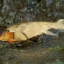

In [9]:
timesteps = list(reversed(range(40)))
generator = None

with torch.no_grad():
    batch_size=1
    img_size=pipe.unet.config.sample_size
    
    sample = pipe.prepare_latents(
                batch_size=batch_size,
                num_channels=pipe.unet.config.in_channels,
                height=img_size,
                width=img_size,
                dtype=pipe.unet.dtype,
                device=device,
                generator=generator,
                latents=None,
            )
    
    
    pipe.scheduler.set_timesteps(timesteps=timesteps, device=device)
    timesteps = pipe.scheduler.timesteps

    print(timesteps)
    print(pipe.scheduler.sigmas)
    
    for t in timesteps:
        
        scaled_sample = pipe.scheduler.scale_model_input(sample, t)
        
        model_output = pipe.unet(
            scaled_sample, 
            t, 
            class_labels=torch.tensor([0], device=device), 
            return_dict=False
        )[0]

        output = pipe.postprocess_image(model_output)
    
        sample = pipe.scheduler.step(model_output, t, sample, generator=generator)[0]
    
    image = pipe.postprocess_image(sample)

image[0]

In [10]:
SAMPLE_ORIG = sample

## Noising the Sample

In [11]:
timesteps=list(reversed(range(40)))

pipe.scheduler.set_timesteps(timesteps=timesteps, device=device)

timesteps = pipe.scheduler.timesteps

print(timesteps)

noise=torch.randn(size=sample.shape).to(device)

tensor([ 1095.5067,  1060.1552,  1024.0748,   987.2349,   949.6027,   911.1435,
          871.8200,   831.5925,   790.4186,   748.2525,   705.0453,   660.7442,
          615.2925,   568.6287,   520.6865,   471.3938,   420.6723,   368.4367,
          314.5939,   259.0417,   201.6680,   142.3495,    80.9495,    17.3166,
          -48.7176,  -117.3416,  -188.7668,  -263.2317,  -341.0065,  -422.3993,
         -507.7631,  -597.5054,  -692.0998,  -792.1010,  -898.1648, -1011.0740,
        -1131.7736, -1261.4188, -1401.4425, -1553.6520], device='cuda:0',
       dtype=torch.float64)


In [12]:
#timesteps=[1, 0]
#pipe.scheduler.set_timesteps(timesteps=timesteps, device=device)
print(pipe.scheduler.timesteps)
print(pipe.scheduler.sigmas)

tensor([ 1095.5067,  1060.1552,  1024.0748,   987.2349,   949.6027,   911.1435,
          871.8200,   831.5925,   790.4186,   748.2525,   705.0453,   660.7442,
          615.2925,   568.6287,   520.6865,   471.3938,   420.6723,   368.4367,
          314.5939,   259.0417,   201.6680,   142.3495,    80.9495,    17.3166,
          -48.7176,  -117.3416,  -188.7668,  -263.2317,  -341.0065,  -422.3993,
         -507.7631,  -597.5054,  -692.0998,  -792.1010,  -898.1648, -1011.0740,
        -1131.7736, -1261.4188, -1401.4425, -1553.6520], device='cuda:0',
       dtype=torch.float64)
tensor([8.0000e+01, 6.9451e+01, 6.0117e+01, 5.1880e+01, 4.4630e+01, 3.8266e+01,
        3.2697e+01, 2.7837e+01, 2.3610e+01, 1.9946e+01, 1.6780e+01, 1.4055e+01,
        1.1719e+01, 9.7232e+00, 8.0265e+00, 6.5901e+00, 5.3800e+00, 4.3656e+00,
        3.5197e+00, 2.8184e+00, 2.2404e+00, 1.7672e+00, 1.3824e+00, 1.0717e+00,
        8.2294e-01, 6.2540e-01, 4.6998e-01, 3.4892e-01, 2.5563e-01, 1.8459e-01,
        1.3120e-01

In [13]:
SIGMAS = pipe.scheduler.sigmas

In [14]:
len(SIGMAS)

41

In [15]:
out = pipe.scheduler.add_noise(SAMPLE_ORIG, noise=noise, timesteps=timesteps)

In [16]:
len(out)

40

In [17]:
imgs = pipe.postprocess_image(out)
#[display(img) for img in imgs]

In [18]:
import numpy as np
imgs = pipe.postprocess_image(out, "np")
imgs = np.concatenate(imgs[::-1], axis=1)
imgs.shape

(64, 2560, 3)

<function matplotlib.pyplot.tight_layout(*, pad: 'float' = 1.08, h_pad: 'float | None' = None, w_pad: 'float | None' = None, rect: 'tuple[float, float, float, float] | None' = None) -> 'None'>

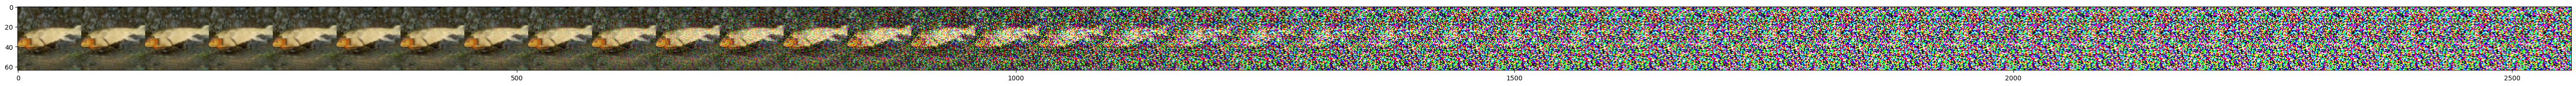

In [19]:
import matplotlib.pyplot as plt
plt.figure(figsize=(70,7))
plt.imshow(imgs)
plt.tight_layout
#plt.savefig("jul19/noising.jpg", dpi=500)

## Denoising the sample

tensor(3.9063e-05) tensor(0.5000)


/tmp/ipykernel_22419/1125244949.py:35: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(out, dtype=torch.float16)[None, :]


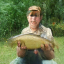

tensor(5.1831e-05) tensor(0.5000)


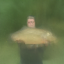

tensor(6.9173e-05) tensor(0.5000)


tensor(9.2881e-05) tensor(0.5000)


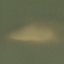

tensor(0.0001) tensor(0.4999)


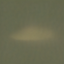

tensor(0.0002) tensor(0.4999)


tensor(0.0002) tensor(0.4999)


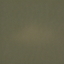

tensor(0.0003) tensor(0.4999)


tensor(0.0004) tensor(0.4998)


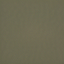

tensor(0.0006) tensor(0.4998)


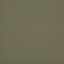

tensor(0.0009) tensor(0.4997)


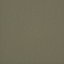

tensor(0.0013) tensor(0.4996)


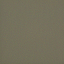

tensor(0.0018) tensor(0.4995)


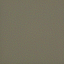

tensor(0.0026) tensor(0.4992)


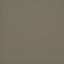

tensor(0.0039) tensor(0.4989)


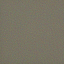

tensor(0.0057) tensor(0.4984)


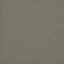

tensor(0.0086) tensor(0.4977)


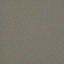

tensor(0.0130) tensor(0.4965)


tensor(0.0198) tensor(0.4947)


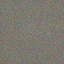

tensor(0.0306) tensor(0.4920)


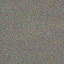

tensor(0.0475) tensor(0.4876)


tensor(0.0743) tensor(0.4806)


tensor(0.1160) tensor(0.4695)


tensor(0.1793) tensor(0.4523)


tensor(0.2706) tensor(0.4263)


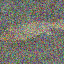

tensor(0.3915) tensor(0.3893)


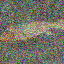

tensor(0.5330) tensor(0.3410)


tensor(0.6750) tensor(0.2845)


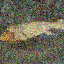

tensor(0.7953) tensor(0.2258)


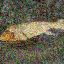

tensor(0.8823) tensor(0.1713)


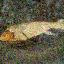

tensor(0.9374) tensor(0.1250)


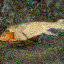

tensor(0.9689) tensor(0.0882)


tensor(0.9854) tensor(0.0603)


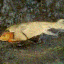

tensor(0.9936) tensor(0.0399)


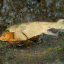

tensor(0.9974) tensor(0.0255)


tensor(0.9990) tensor(0.0155)


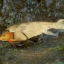

tensor(0.9997) tensor(0.0088)


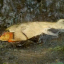

tensor(0.9999) tensor(0.0044)


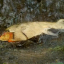

tensor(1.0000) tensor(0.0017)


tensor(1.) tensor(0.)


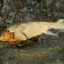

'\n    # compute MSE\n    diff_dn_s = torch.tensor(denoised_sample - SAMPLE_ORIG, dtype=torch.float32).clone().detach().cpu()\n    mse.append(torch.sum(diff_dn_s * diff_dn_s))\n\n    # compute bias\n    diff_dn_n = torch.tensor(denoised_sample - out[t][None, :], dtype=torch.float32).clone().detach().cpu()\n    bias.append(torch.sum(diff_dn_n * diff_dn_n))\n    #bias.append(torch.sum(denoised_sample * denoised_sample).clone().detach().cpu())\n\n    def denoise_sample_v(s_v):\n        s = torch.reshape(s_v, (1,3,64,64))\n        denoised_sample = denoise_sample(s, timesteps[t])\n        return torch.reshape(denoised_sample, (12288,))\n\n    noisy_sample_v = torch.reshape(help(out[t]), (12288,))\n\n    trace = torch.tensor(0, device=device, dtype=torch.float)\n    for j in range(N_TRACE):\n        eps = torch.randn((12288,), device=device)\n        prod =  vjp(denoise_sample_v, inputs=noisy_sample_v, v=eps)[1]\n        trace += torch.sum(eps * prod)\n\n    trace /= N_TRACE\n\n    traces.a

In [21]:
from torch.autograd.functional import jacobian, vjp

N_TRACE = 20

def denoise_sample(sample, sigma):
#def denoise_sample(sample, timestep):
    #t = timestep
    t = pipe.scheduler.sigma_to_t(sigma)
    
    scaled_sample = pipe.scheduler.scale_model_input(sample, t)
    
    model_output = pipe.unet(
        scaled_sample, 
        t, 
        class_labels=torch.tensor([0], device=device), 
        return_dict=False
    )[0]

    #idx = pipe.scheduler.index_for_timestep(t)

    #sigma = pipe.scheduler.sigmas[idx + 1]

    c_skip, c_out = pipe.scheduler.get_scalings_for_boundary_condition(sigma)

    denoised = c_out * model_output + c_skip * sample
    #denoised = c_skip * sample

    print(c_skip, c_out)

    #denoised = model_output 

    return denoised

def help(out):
    return torch.tensor(out, dtype=torch.float16)[None, :]

mse = []
bias = []
traces = []

denoised_samples = []


for t in range(40):
    # display(pipe.postprocess_image(out[t][None, :])[0])
    denoised_sample = denoise_sample(
        help(out[t]), 
        #timesteps[t],
        SIGMAS[t]
    )
    denoised_samples.append(denoised_sample.clone().detach())

    img = pipe.postprocess_image(denoised_sample.detach().cpu())[0]

    display(img)
    
"""
    # compute MSE
    diff_dn_s = torch.tensor(denoised_sample - SAMPLE_ORIG, dtype=torch.float32).clone().detach().cpu()
    mse.append(torch.sum(diff_dn_s * diff_dn_s))

    # compute bias
    diff_dn_n = torch.tensor(denoised_sample - out[t][None, :], dtype=torch.float32).clone().detach().cpu()
    bias.append(torch.sum(diff_dn_n * diff_dn_n))
    #bias.append(torch.sum(denoised_sample * denoised_sample).clone().detach().cpu())

    def denoise_sample_v(s_v):
        s = torch.reshape(s_v, (1,3,64,64))
        denoised_sample = denoise_sample(s, timesteps[t])
        return torch.reshape(denoised_sample, (12288,))

    noisy_sample_v = torch.reshape(help(out[t]), (12288,))

    trace = torch.tensor(0, device=device, dtype=torch.float)
    for j in range(N_TRACE):
        eps = torch.randn((12288,), device=device)
        prod =  vjp(denoise_sample_v, inputs=noisy_sample_v, v=eps)[1]
        trace += torch.sum(eps * prod)

    trace /= N_TRACE

    traces.append(trace)
"""

#TRACES_SAVE = traces

/tmp/ipykernel_8264/2207124256.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  imgs_denoised = torch.tensor(torch.cat(denoised_samples, axis=0), dtype=torch.float32)


<function matplotlib.pyplot.tight_layout(*, pad: 'float' = 1.08, h_pad: 'float | None' = None, w_pad: 'float | None' = None, rect: 'tuple[float, float, float, float] | None' = None) -> 'None'>

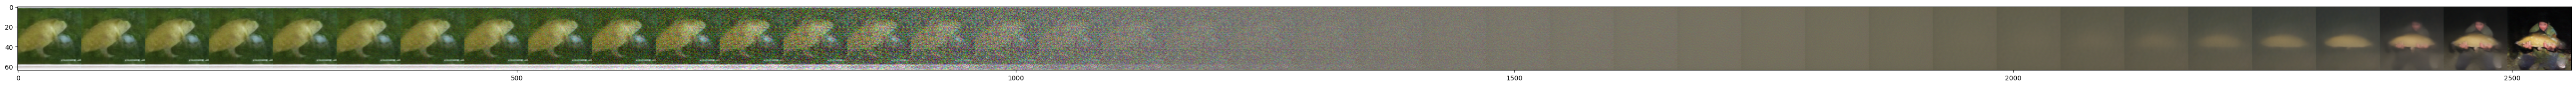

In [33]:
imgs_denoised = torch.tensor(torch.cat(denoised_samples, axis=0), dtype=torch.float32)

imgs_denoised = pipe.postprocess_image(imgs_denoised, output_type="np")
imgs_denoised = np.concatenate(imgs_denoised[::-1], axis=1)

import matplotlib.pyplot as plt
plt.figure(figsize=(70,7))
plt.imshow(imgs_denoised)
plt.tight_layout
#plt.savefig("jul19/denoising.jpg", dpi=500)

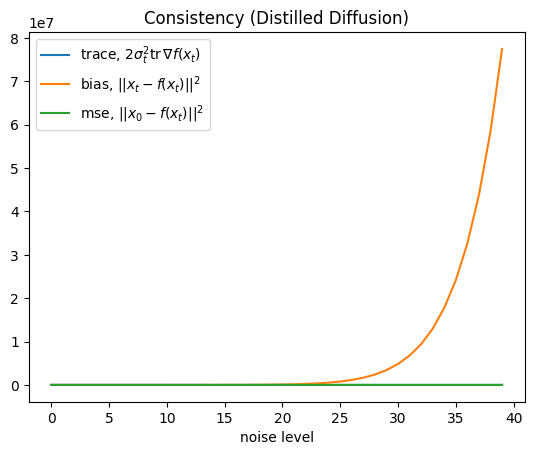

In [39]:
#traces = [_.clone().detach().cpu() * 2 * pipe.scheduler.sigmas[pipe.scheduler.index_for_timestep(j)]**2 for j, _ in zip(timesteps, TRACES_SAVE)]
#traces = [_.clone().detach().cpu() for j, _ in zip(timesteps, TRACES_SAVE)]
traces = [_.clone().detach().cpu() for _ in TRACES_SAVE]


#plt.plot(traces, label="var, $2 \\sigma_t^2 \\, \\text{tr} \\, \\nabla f(x_t)$")
plt.plot(traces[::-1], label="trace, $2 \\sigma_t^2 \\text{tr} \\, \\nabla f(x_t)$")
plt.plot(bias[::-1], label="bias, $||x_t - f(x_t)||^2$")
plt.plot(mse[::-1], label="mse, $||x_0 - f(x_t)||^2$")

SURE = [
    traces[i] 
    + bias[i] 
    - 12288 * pipe.scheduler.sigmas[pipe.scheduler.index_for_timestep(t)]
    for i, t in enumerate(timesteps) 
]

#plt.plot(SURE[::-1], label="SURE")


plt.xlabel("noise level")
plt.title("Consistency (Distilled Diffusion)")

plt.legend()

#plt.savefig("jul19/bias_var_tradeoff_rescaled.jpg", dpi=300)

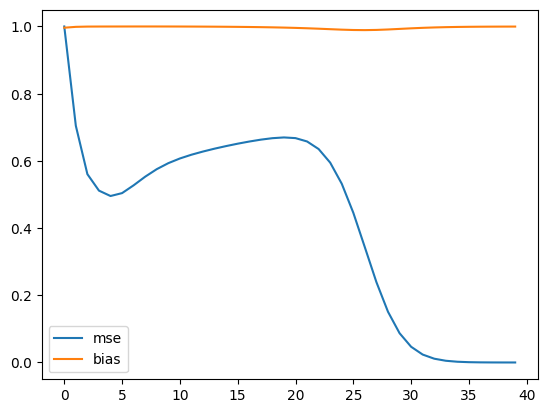

In [62]:
import matplotlib.pyplot as plt
import numpy as np
plt.plot(mse / np.max(mse), label="mse")
plt.plot(bias / np.max(bias), label="bias")
plt.legend()

In [ ]:
timesteps = [0]
generator = None
with torch.no_grad():
    batch_size=1
    img_size=pipe.unet.config.sample_size
    
    sample = pipe.prepare_latents(
                batch_size=batch_size,
                num_channels=pipe.unet.config.in_channels,
                height=img_size,
                width=img_size,
                dtype=pipe.unet.dtype,
                device=device,
                generator=generator,
                latents=None,
            )
    
    
    pipe.scheduler.set_timesteps(timesteps=timesteps, device=device)
    timesteps = pipe.scheduler.timesteps

    
    for t in timesteps:
        
        scaled_sample = pipe.scheduler.scale_model_input(sample, t)
        model_output = pipe.unet(
            scaled_sample, 
            t, 
            class_labels=torch.tensor([0], device=device), 
            return_dict=False
        )[0]

        output = pipe.postprocess_image(model_output)
    
        sample = pipe.scheduler.step(model_output, t, sample, generator=generator)[0]
    
    image = pipe.postprocess_image(sample)

output[0]